<font size="2"> 

# Filtro Butterworth

Neste notebook vamos explorar o projeto de Filtros Butterworth. Tais filtros, são Sistemas Lineares e Invariantes no Tempo (SLIT). Eles tem propriedades interessantes como: magnitude constante na banda de passagem. Vamos começar a especificação de um  filtro ***passa-baixa***, cuja resposta de ***magnitude***, que é dada por


\begin{equation}
|B(\mathrm{j}\omega)|^2 = \frac{1}{1+(\mathrm{j}\omega/\mathrm{j}\omega_c)^{2N}}
\tag{1}
\end{equation}

em que $\omega$ é a frequência angular, $\omega_c$ e $N$ são a frequência angular de corte e a ordem do filtro, respectivamente.

Vamos plotar a magnitude em função da ordem. Observe que à medida que $N$ aumenta, o banda de corte do filtro torna-se mais e mais inclinada (maior taxa de corte dB/8$^{va}$).
</font>

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf
# Os próximos módulos são usados pra criar nosso SLIT
from scipy.signal import butter, lfilter, freqs, tf2sos, sosfilt

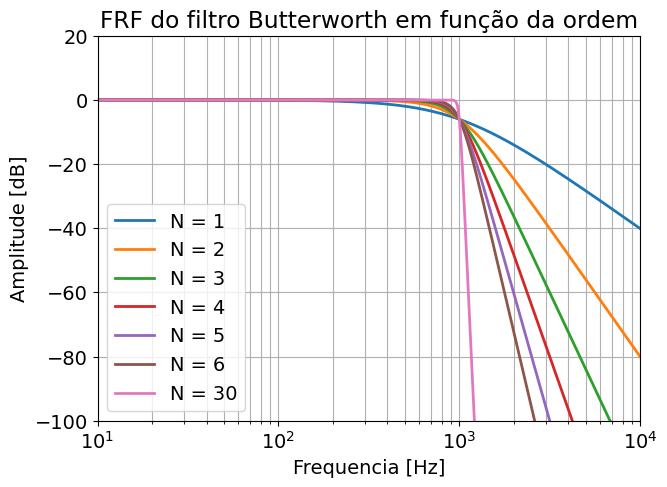

In [2]:
Nset = [1,2,3,4,5,6, 30]
f = np.arange(10, 10001, 1)
omega = 2*np.pi*f
fc = 1000
omegac = 2*np.pi*fc

plt.figure(figsize=(7,5))

for N in Nset:
    B2 = 1/(1+((1j*omega)/(1j*omegac))**(2*N))
    plt.semilogx(f, 20 * np.log10(abs(B2)), linewidth = 2, label = 'N = ' + str(N))
plt.legend(loc = 'lower left')
plt.title('FRF do filtro Butterworth em função da ordem')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.ylim((-100, 20));


<font size="2"> 
Por definição $|B(\mathrm{j}\omega)|^2 = B(\mathrm{j}\omega) B^{*}(\mathrm{j}\omega)$. Além disso, se desejamos um filtro com resposta ao impulso, $h(t)$, real, então $B^{*}(\mathrm{j}\omega) = B(-\mathrm{j}\omega)$. Dessa forma,

\begin{equation}
B(\mathrm{j}\omega)B(-\mathrm{j}\omega) = \frac{1}{1+(\mathrm{j}\omega/\mathrm{j}\omega_c)^{2N}}
\tag{2}
\end{equation}

Nós também desejamos que o filtro seja

- ***causal***: sinal de saída, $y(t)$, depende de instantes presentes ou passados de $x(t)$ e
- ***estável***

Assim, a RDC da transformada de Laplace do filtro deve conter o eixo $\mathrm{j}\omega$ e, podemos notar que: $B(s)|_{s=\mathrm{j}\omega} = B(\mathrm{j}\omega)$ e

\begin{equation}
B(s)B(-s) = \frac{1}{1+(s/\mathrm{j}\omega_c)^{2N}}
\tag{3}
\end{equation}

Da Eq. (3), as raízes do polinômio do denominador de $B(s)B(-s)$ estão em:

\begin{equation}
s_p = (-1)^{\frac{1}{2N}}(\mathrm{j}\omega_c)
\tag{4}
\end{equation}

cuja magnitude é

\begin{equation}
|s_p| = \omega_c
\tag{5}
\end{equation}
e a fase é

\begin{equation}
\angle s_p = \frac{\pi(2k+1)}{2N} + \frac{\pi}{2}, \hspace{1cm} k = 1,2,...,2N
\tag{6}
\end{equation}

Podemos plotar as raízes da Eq. (4) no plano complexo. Vamos criar algumas funções pra isso.

</font>

In [3]:
def calc_poles(N, omegac):
    """
    Function to calculate the poles of B(s)B(-s)
    inputs:
        N - filter order
        omegac - cutoff angular frequency of the filter (to plot the cuttoff circle)
    """
    sp = []
    for k in np.arange(0,2*N):
        s = omegac*np.exp(1j*(np.pi*(2*k+1)/(2*N)+np.pi/2))
        sp.append(s)
    return sp

def plot_poles(sp = [-1 + 1j*2, -1 - 1j*2], omegac = 2, fill=False):
    """
    Function to plot poles on the complex plane
    inputs:
        sp - list of poles
        omegac - cutoff angular frequency of the filter (to plot the cuttoff circle)
    """
    #circle
    theta = np.linspace(0, 2*np.pi, 500)
    re = omegac*np.cos(theta)
    im = omegac*np.sin(theta)
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    for s in sp:
        ax.scatter(np.real(s), np.imag(s), marker = 'x', s = 150, c = 'r')
    ax.plot(re,im, '--k')
    ax.set_xlabel(r'$\Re e\left\{ s \right\} = \sigma$', x = 1)
    ax.set_ylabel(r'$\Im m\left\{ s \right\} = \mathrm{j}\omega$', ha='left',  y = 1, rotation =0)    
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot((1), (0), ls="", marker=">", ms=10, color="k",
        transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((0), (1), ls="", marker="^", ms=10, color="k",
        transform=ax.get_xaxis_transform(), clip_on=False)
    ax.set_xlim((-3*omegac, 3*omegac))
    ax.set_ylim((-3*omegac, 3*omegac))
    if fill == True:
        s_rightmost = np.amax(np.real(sp))
        y_fill = np.arange(-3*omegac, 3*omegac, 0.5 )
        ax.fill_betweenx(y_fill, s_rightmost*np.ones(len(y_fill)), 3*omegac*np.ones(len(y_fill)), alpha = 0.3)
    #plt.tight_layout()

<font size="2"> 

## Polos de $B(s)B(-s)$

A seguir plotamos os polos de $B(s)B(-s)$. Note que:

1. Existem $2N$ polos igualmente espaçados em ângulo na circunferência de raio $\omega_c$
2. O espaçamento angular entre os polos é $\pi/N$
3. Podemos ter polos puramente reais ou pares complexos conjugados
4. Um polo nunca se encontra sobre o eixo $\mathrm{j}\omega$
5. Há polos à esquerda ou à direita do eixo $\mathrm{j}\omega$

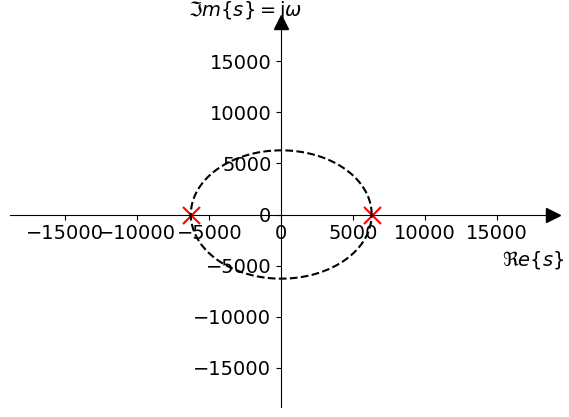

In [12]:
# Filtro - ordem N
N = 1
sp = calc_poles(N, omegac)
plot_poles(sp = np.array([sp]), omegac = omegac)

<font size="2"> 
    
## Polos de $B(s)$

Para escolher os polos de $B(s)$ podemos escolher os pares de polos (complexos conjugados) que nos levem a um sistema

- causal
- estável

Vamos então, criar um filtro estável com o ***scipy***, plotar a resposta em frequência e os polos do SLIT estável e causal e comparar com o caso dos polos de $B(s)B(-s)$

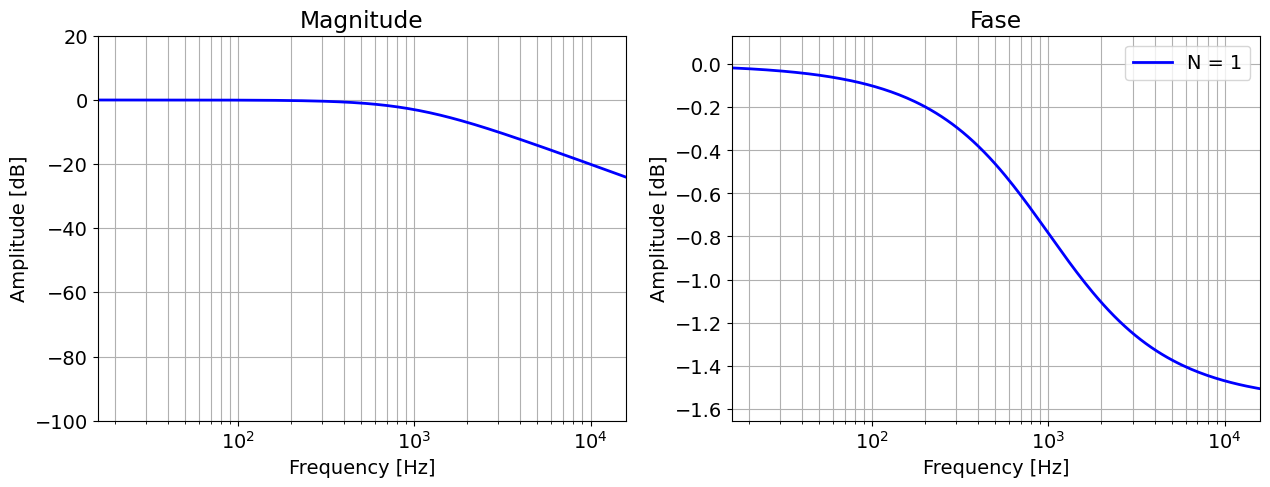

In [13]:
b, a = butter(N, omegac, btype='low', analog=True)
w, H = freqs(b, a)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(H)), 'b', linewidth = 2)
plt.title('Magnitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.ylim((-100, 20))

plt.subplot(1,2,2)
plt.semilogx(w/(2*np.pi), np.angle(H), 'b', linewidth = 2, label = 'N = ' + str(N))
plt.legend(loc = 'upper right')
plt.title('Fase')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.show()

In [14]:
print(b)
print(a)

[6283.18530718]
[1.00000000e+00 6.28318531e+03]


<font size="2"> 

Finalmente, plotamos os polos deste filtro e comparamos com o caso anterior.

H(s) = 6283.19/(1.00s + 6283.19)


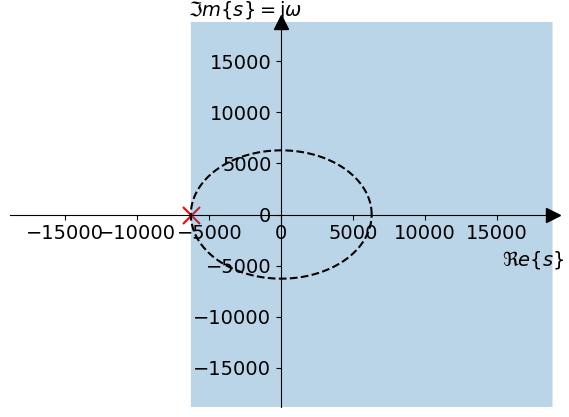

In [15]:
sp = np.roots(a)
plot_poles(sp = np.array([sp]), omegac = omegac, fill = True)
if N == 1:
    print('H(s) = {:.2f}/({:.2f}s + {:.2f})'.format(b[0],a[0],a[1]))
else:
    print('A ordem do filtro é {}'.format(N))